# Imports 

In [2]:
import pandas as pd

from datetime import datetime
from coinmetrics.api_client import CoinMetricsClient
import logging

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import coint

# Data

## US M2 From FRED

In [5]:
# download from https://fred.stlouisfed.org/series/WM2NS and rename accordingly: 

m2_df = pd.read_csv('WM2NS_03_09_2025.csv')

# Convert 'observation_date' to datetime in m2w_df and set it as the index
m2_df['observation_date'] = pd.to_datetime(m2_df['observation_date'])
m2_df.set_index('observation_date', inplace=True)

m2_df.info()
m2_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 788 entries, 2010-01-04 to 2025-02-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WM2NS   788 non-null    float64
dtypes: float64(1)
memory usage: 12.3 KB


,WM2NS
observation_date,
2010-01-04,8552.1
2010-01-11,8513.5
2010-01-18,8497.2
2010-01-25,8432.4
2010-02-01,8450.6
...,...
2025-01-06,21707.1
2025-01-13,21722.0
2025-01-20,21642.6


## BTC

In [7]:
# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define the asset, metric, and time range
asset = 'btc'
metric = 'PriceUSD'
start_time = '2010-01-01'
end_time = datetime.today().strftime('%Y-%m-%d')  # Set end_time to today's date
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
btc_df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename the 'ReferenceRate' column to 'Close'
btc_df = btc_df.rename(columns={metric: 'Close'})

# Set 'time' as the index and normalize to remove the time component but keep it as a DatetimeIndex
btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()

# Remove timezone information, if any
btc_df['time'] = btc_df['time'].dt.tz_localize(None)

# Set 'time' as the index
btc_df.set_index('time', inplace=True)

# Only keep close data
btc_df = btc_df[['Close']]

# Rename "Close" TO "BTC"
btc_df = btc_df.rename(columns={"Close": "BTC"})

# Display
btc_df.info()
btc_df

2025-03-09 18:47:49 INFO     Fetching BTC ReferenceRate...
2025-03-09 18:47:51 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-09 18:47:59 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-09 18:48:07 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5349 entries, 2010-07-18 to 2025-03-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     5349 non-null   Float64
dtypes: Float64(1)
memory usage: 88.8 KB


,BTC
time,
2010-07-18,0.08584
2010-07-19,0.0808
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.05847
...,...
2025-03-05,90619.409098
2025-03-06,90222.069328
2025-03-07,86553.592194


## Merge BTC & US M2

In [9]:
# Merge the DataFrames on their indexes (intersection of dates)
m2btc_df = btc_df.merge(m2_df, left_index=True, right_index=True, how='inner')

m2btc_df = m2btc_df.astype('float64')

# Display the merged DataFrame structure
m2btc_df.info()
m2btc_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 760 entries, 2010-07-19 to 2025-02-03
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     760 non-null    float64
 1   WM2NS   760 non-null    float64
dtypes: float64(2)
memory usage: 17.8 KB


,BTC,WM2NS
2010-07-19,0.080800,8595.1
2010-07-26,0.056000,8555.1
2010-08-02,0.060000,8604.3
2010-08-09,0.070400,8644.9
2010-08-16,0.065500,8650.6
...,...,...
2025-01-06,102179.560367,21707.1
2025-01-13,94375.729910,21722.0
2025-01-20,102588.998699,21642.6
2025-01-27,101907.446297,21544.0


In [10]:
def plot_dual_series(df, col1, col2):
    """
    Plots two time series with separate y-axes on a black background.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    col1 (str): Column name for the first series (left y-axis).
    col2 (str): Column name for the second series (right y-axis).

    Returns:
    None: The function displays the plot.
    """
    # Create a figure with a black background
    fig, ax1 = plt.subplots(figsize=(12, 7))
    fig.patch.set_facecolor('black')
    ax1.set_facecolor('black')

    # Use a custom color palette
    palette = sns.color_palette()

    # Plot the first series on the left y-axis
    ax1.plot(df.index, df[col1], label=col1, color=palette[0], linewidth=2)
    ax1.set_ylabel(col1, color=palette[0], fontsize=12)
    ax1.tick_params(axis='y', colors=palette[0])

    # Create a second y-axis for the second series
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[col2], label=col2, color=palette[7], linewidth=2)
    ax2.set_ylabel(col2, color=palette[7], fontsize=12)
    ax2.tick_params(axis='y', colors=palette[7])

    # Formatting the plot
    ax1.set_title(f'{col1} and {col2} Over Time', fontsize=16, color='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of x-axis ticks for readability

    # Set the grid color and style
    ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

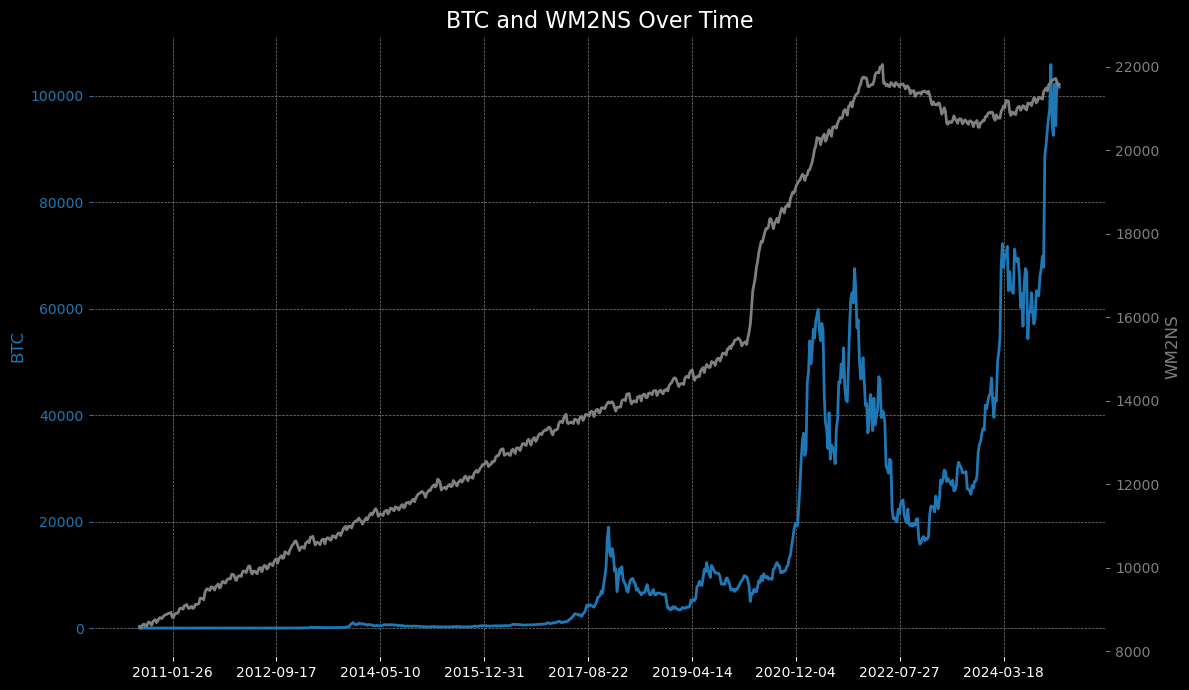

In [11]:
plot_dual_series(m2btc_df, 'BTC', 'WM2NS')

# Analysis

## Order of Integration (Cointegration Prerequisite)

In [14]:
# Apply log-differencing to make the series stationary
m2btc_df['BTC_diff'] = np.log(m2btc_df['BTC']).diff()
m2btc_df['WM2NS_diff'] = np.log(m2btc_df['WM2NS']).diff()

# Drop NaN values resulting from differencing
m2btc_df.dropna(inplace=True)

m2btc_df

,BTC,WM2NS,BTC_diff,WM2NS_diff
2010-07-26,0.056000,8555.1,-0.366625,-0.004665
2010-08-02,0.060000,8604.3,0.068993,0.005734
2010-08-09,0.070400,8644.9,0.159849,0.004707
2010-08-16,0.065500,8650.6,-0.072143,0.000659
2010-08-23,0.064910,8598.9,-0.009048,-0.005994
...,...,...,...,...
2025-01-06,102179.560367,21707.1,0.099273,0.000585
2025-01-13,94375.729910,21722.0,-0.079448,0.000686
2025-01-20,102588.998699,21642.6,0.083447,-0.003662
2025-01-27,101907.446297,21544.0,-0.006666,-0.004566


In [15]:
def analyze_series(df, column):
    """
    Perform stationarity and autocorrelation tests on a given time series.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the time series.
    - column (str): The column name of the series to analyze.
    
    Returns:
    - dict: A dictionary containing ADF and Durbin-Watson test results.
    """
    results = {}

    # Perform Augmented Dickey-Fuller (ADF) test
    adf_result = adfuller(df[column])
    adf_statistic, p_value = adf_result[0], adf_result[1]
    results['ADF Statistic'] = adf_statistic
    results['p-value'] = p_value
    results['ADF Interpretation'] = (
        "Stationary" if p_value < 0.05 
        else "Non-stationary"
    )

    # Add intercept for regression
    df = df.copy()
    df['Intercept'] = 1

    # Fit a simple linear regression model to obtain residuals
    model = sm.OLS(df[column], df[['Intercept']]).fit()

    # Perform Durbin-Watson test for autocorrelation
    dw_statistic = durbin_watson(model.resid)
    results['Durbin-Watson Statistic'] = dw_statistic
    if 1.5 < dw_statistic < 2.5:
        results['DW Interpretation'] = "No significant autocorrelation"
    elif dw_statistic <= 1.5:
        results['DW Interpretation'] = "Positive autocorrelation detected"
    else:
        results['DW Interpretation'] = "Negative autocorrelation detected"

    return results

In [16]:
print("ALL HISTORICAL DATA:")
print("")
entire_df = m2btc_df

print("BTC:")
all_btc_result = analyze_series(entire_df, 'BTC_diff')
display(all_btc_result)

print("")
print("M2:")
all_m2_result = analyze_series(entire_df, 'WM2NS_diff')
display(all_m2_result)

###############################################################################

print("")
print("LAST 8 YEARS:")
print("")
recent_df = m2btc_df.loc['2017-01-01':]

print("BTC:")
recent_btc_result = analyze_series(recent_df, 'BTC_diff')
display(recent_btc_result)

print("")
print("M2:")
recent_m2_result = analyze_series(recent_df, 'WM2NS_diff')
display(recent_m2_result)

###############################################################################

print("")
print("POST COVID:")
print("")
post_covid_df = m2btc_df.loc['2022-01-01':]

print("BTC:")
post_covid_btc_result = analyze_series(post_covid_df, 'BTC_diff')
display(post_covid_btc_result)

print("")
print("M2:")
post_covid_m2_result = analyze_series(post_covid_df, 'WM2NS_diff')
display(post_covid_m2_result)

ALL HISTORICAL DATA:

BTC:


{'ADF Statistic': -9.634228782199765,
 'p-value': 1.5822775267218797e-16,
 'ADF Interpretation': 'Stationary',
 'Durbin-Watson Statistic': 1.7461742079554374,
 'DW Interpretation': 'No significant autocorrelation'}


M2:


{'ADF Statistic': -4.181803329279654,
 'p-value': 0.0007072235186595726,
 'ADF Interpretation': 'Stationary',
 'Durbin-Watson Statistic': 1.8806884650185074,
 'DW Interpretation': 'No significant autocorrelation'}


LAST 8 YEARS:

BTC:


{'ADF Statistic': -19.76451487166229,
 'p-value': 0.0,
 'ADF Interpretation': 'Stationary',
 'Durbin-Watson Statistic': 1.922349161168031,
 'DW Interpretation': 'No significant autocorrelation'}


M2:


{'ADF Statistic': -3.465864231530981,
 'p-value': 0.008908291607633515,
 'ADF Interpretation': 'Stationary',
 'Durbin-Watson Statistic': 1.6867837757441175,
 'DW Interpretation': 'No significant autocorrelation'}


POST COVID:

BTC:


{'ADF Statistic': -13.043088000617406,
 'p-value': 2.2202264606961258e-24,
 'ADF Interpretation': 'Stationary',
 'Durbin-Watson Statistic': 2.0511474062188455,
 'DW Interpretation': 'No significant autocorrelation'}


M2:


{'ADF Statistic': -2.422649304270562,
 'p-value': 0.1354455806354753,
 'ADF Interpretation': 'Non-stationary',
 'Durbin-Watson Statistic': 2.047888443463724,
 'DW Interpretation': 'No significant autocorrelation'}

BTC is clearly I1 since its log difference is stationary across all 3 durations (all, last 8 years, post covid). However, US M2 needs further inspection, specifically for the post covid duration.  

In [18]:
def check_pp_test(df, column):
    """
    Performs the Phillips-Perron test for stationarity on a given column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to analyze.

    Returns:
    dict: A dictionary containing the PP test statistic, p-value, and interpretation.
    """
    pp_test = PhillipsPerron(df[column].dropna())
    
    results = {
        "PP Statistic": pp_test.stat,
        "p-value": pp_test.pvalue,
        "PP Interpretation": "Stationary" if pp_test.pvalue < 0.05 else "Non-stationary"
    }
    
    return results

# Run the test for post-COVID M2
pp_m2_result = check_pp_test(post_covid_df, 'WM2NS_diff')
print(pp_m2_result)

{'PP Statistic': -13.165668240958718, 'p-value': 1.2805413177966317e-24, 'PP Interpretation': 'Stationary'}


Now it's fair to say US M2 is I1 as well since the log difference shows stationarity.

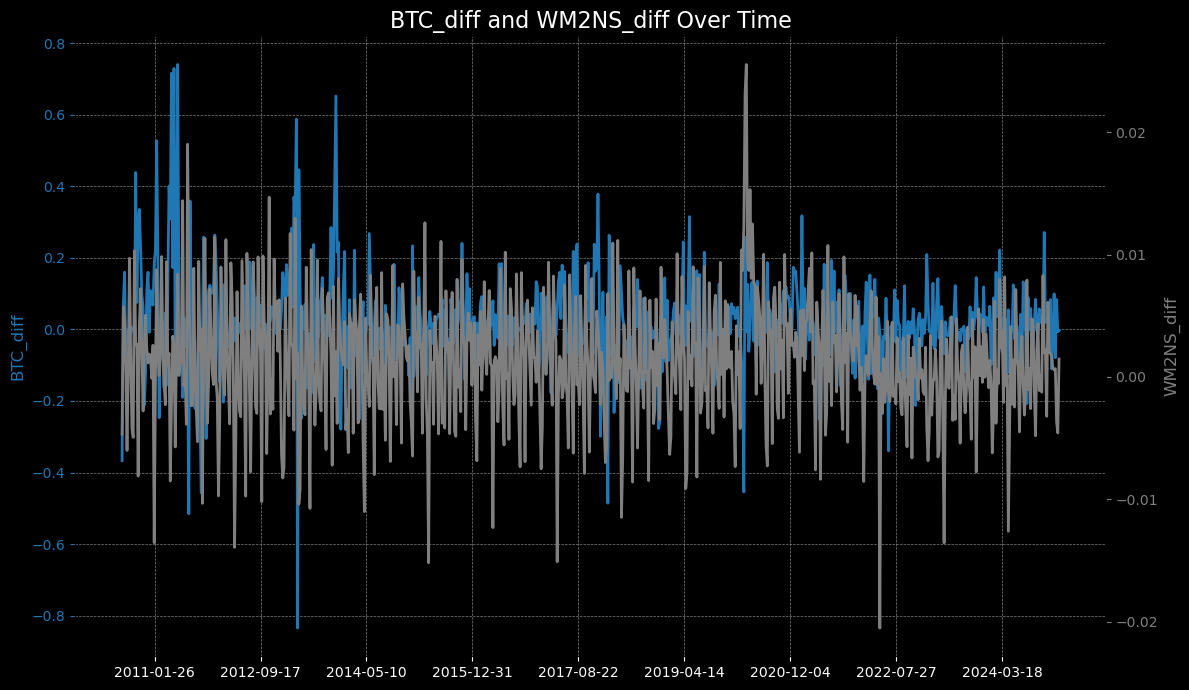

In [20]:
plot_dual_series(m2btc_df, 'BTC_diff', 'WM2NS_diff')

## Cointegration

Both series are I1 (One Diff made them I0), so now we can consider cointegration tests. 

### Testing Cointegration Across 3 Periods (2010-Now, 2017-NOW, 2022-NOW)

In [24]:
def cointegration_test(df, col1, col2):
    """
    Performs the Engle-Granger cointegration test between two non-stationary time series.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the series.
    - col1 (str): The first column for the test (must be I(1)).
    - col2 (str): The second column for the test (must be I(1)).

    Returns:
    - dict: A dictionary containing the cointegration test statistic, p-value, and interpretation.
    """
    score, p_value, _ = coint(df[col1].dropna(), df[col2].dropna())
    results = {
        "Cointegration Statistic": score,
        "p-value": p_value,
        "Interpretation": "Cointegrated" if p_value < 0.05 else "Not Cointegrated"
    }
    return results

# Define the different time periods
entire_df = m2btc_df.copy()
recent_df = m2btc_df.loc['2017-01-01':].copy()
post_covid_df = m2btc_df.loc['2022-01-01':].copy()

# Running cointegration tests on BTC and M2 (WM2NS) for different periods
cointegration_results = {
    "ALL HISTORICAL DATA": cointegration_test(entire_df, 'BTC', 'WM2NS'),
    "LAST 8 YEARS": cointegration_test(recent_df, 'BTC', 'WM2NS'),
    "POST COVID": cointegration_test(post_covid_df, 'BTC', 'WM2NS')
}

# Convert results to a DataFrame for display
cointegration_df = pd.DataFrame.from_dict(cointegration_results, orient='index')
print(cointegration_df)

                     Cointegration Statistic   p-value    Interpretation
ALL HISTORICAL DATA                -0.623621  0.954273  Not Cointegrated
LAST 8 YEARS                       -0.660240  0.950761  Not Cointegrated
POST COVID                          0.663302  0.993482  Not Cointegrated


Cheeky return for Twitter:

In [26]:
def cointegration_test(df, col1, col2, period_name):
    """
    Performs the Engle-Granger cointegration test between two non-stationary time series
    and returns a Twitter-friendly formatted result.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the series.
    - col1 (str): The first column for the test (must be I(1)).
    - col2 (str): The second column for the test (must be I(1)).
    - period_name (str): The label for the time period being tested.

    Returns:
    - str: A formatted string summarizing the cointegration test results.
    """
    score, p_value, _ = coint(df[col1].dropna(), df[col2].dropna())

    # Determine interpretation
    interpretation = "✅ Cointegrated" if p_value < 0.05 else "❌ Not Cointegrated"

    # Twitter-friendly output
    result_text = (
        f"🔍 Engle-Granger Cointegration Test\n"
        f"📅 Time Period: {period_name}\n"
        f"📊 Testing BTC (Bitcoin) vs. WM2NS (M2 Money Supply)\n"
        f"----------------------------------\n"
        f"📉 Cointegration Statistic: {score:.4f}\n"
        f"📊 p-value: {p_value:.6f}\n"
        f"⚖️ Interpretation: {interpretation}\n"
        f"----------------------------------\n"
        f"🧐 If cointegrated, BTC and M2 share a long-term relationship."
    )
    
    return result_text

# Define time periods
entire_df = m2btc_df.copy()
recent_df = m2btc_df.loc['2017-01-01':].copy()
post_covid_df = m2btc_df.loc['2022-01-01':].copy()

# Run cointegration tests and print results
all_time_result = cointegration_test(entire_df, 'BTC', 'WM2NS', "All Historical Data")
last_8_years_result = cointegration_test(recent_df, 'BTC', 'WM2NS', "Last 8 Years")
post_covid_result = cointegration_test(post_covid_df, 'BTC', 'WM2NS', "Post-COVID")

# Print results for easy copy-pasting
print(all_time_result)
print("\n" + "-"*50 + "\n")
print(last_8_years_result)
print("\n" + "-"*50 + "\n")
print(post_covid_result)

🔍 Engle-Granger Cointegration Test
📅 Time Period: All Historical Data
📊 Testing BTC (Bitcoin) vs. WM2NS (M2 Money Supply)
----------------------------------
📉 Cointegration Statistic: -0.6236
📊 p-value: 0.954273
⚖️ Interpretation: ❌ Not Cointegrated
----------------------------------
🧐 If cointegrated, BTC and M2 share a long-term relationship.

--------------------------------------------------

🔍 Engle-Granger Cointegration Test
📅 Time Period: Last 8 Years
📊 Testing BTC (Bitcoin) vs. WM2NS (M2 Money Supply)
----------------------------------
📉 Cointegration Statistic: -0.6602
📊 p-value: 0.950761
⚖️ Interpretation: ❌ Not Cointegrated
----------------------------------
🧐 If cointegrated, BTC and M2 share a long-term relationship.

--------------------------------------------------

🔍 Engle-Granger Cointegration Test
📅 Time Period: Post-COVID
📊 Testing BTC (Bitcoin) vs. WM2NS (M2 Money Supply)
----------------------------------
📉 Cointegration Statistic: 0.6633
📊 p-value: 0.993482
⚖️ In

### Comparing 3 month lag of BTC (US M2 as a lead) 

In [28]:
def process_and_plot(df, from_date='2022-01-01', lead=13):
    """
    Prepares and plots the BTC series along with the WM2NS series shifted forward by a specified number of weeks.
    
    The function:
      - Creates a full copy of the dataset.
      - Filters the data starting from 'from_date'.
      - Extends the date index by 'lead' weeks to include future dates.
      - Creates a leading indicator by shifting WM2NS forward by 'lead' weeks.
      - Plots BTC vs. the leading WM2NS series.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame containing at least 'BTC' and 'WM2NS' columns.
    - from_date (str): Date from which to start plotting data.
    - lead (int): Number of weeks to shift WM2NS forward.
    """
    # Create a full copy of the dataset for safe operations
    complete_df = df.copy()
    
    # Filter the dataset for plotting starting from the specified date
    plot_df = complete_df.loc[from_date:].copy()
    
    # Create new dates for extension: start one week after the last date in plot_df, for 'lead' weeks
    new_dates = pd.date_range(
        start=plot_df.index[-1] + pd.DateOffset(weeks=1),
        periods=lead,
        freq='W-MON'
    )
    
    # Build an extension DataFrame for the additional weeks
    extension_df = pd.DataFrame(index=new_dates)
    # Ensure the 'BTC' column has the same dtype as in plot_df
    btc_dtype = plot_df['BTC'].dtype
    extension_df['BTC'] = pd.Series([None] * len(extension_df), index=new_dates, dtype=btc_dtype)
    
    # Add any missing columns to extension_df with a fill value of pd.NA
    extension_df = extension_df.reindex(columns=plot_df.columns, fill_value=pd.NA)
    
    # Concatenate the extension with the filtered data to form the final DataFrame for plotting
    final_df = pd.concat([plot_df, extension_df])
    
    # Create a leading indicator column for WM2NS by shifting it forward by 'lead' weeks
    lead_column = f'WM2NS_lead_{lead}'
    final_df[lead_column] = complete_df['WM2NS'].shift(-lead)
    
    # Plot the BTC series and the leading WM2NS series using the predefined plotting function
    plot_dual_series(final_df, 'BTC', lead_column)

/var/folders/4w/nd1gpmp52qbd4726k116vdhm0000gn/T/ipykernel_18452/2156481339.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([plot_df, extension_df])


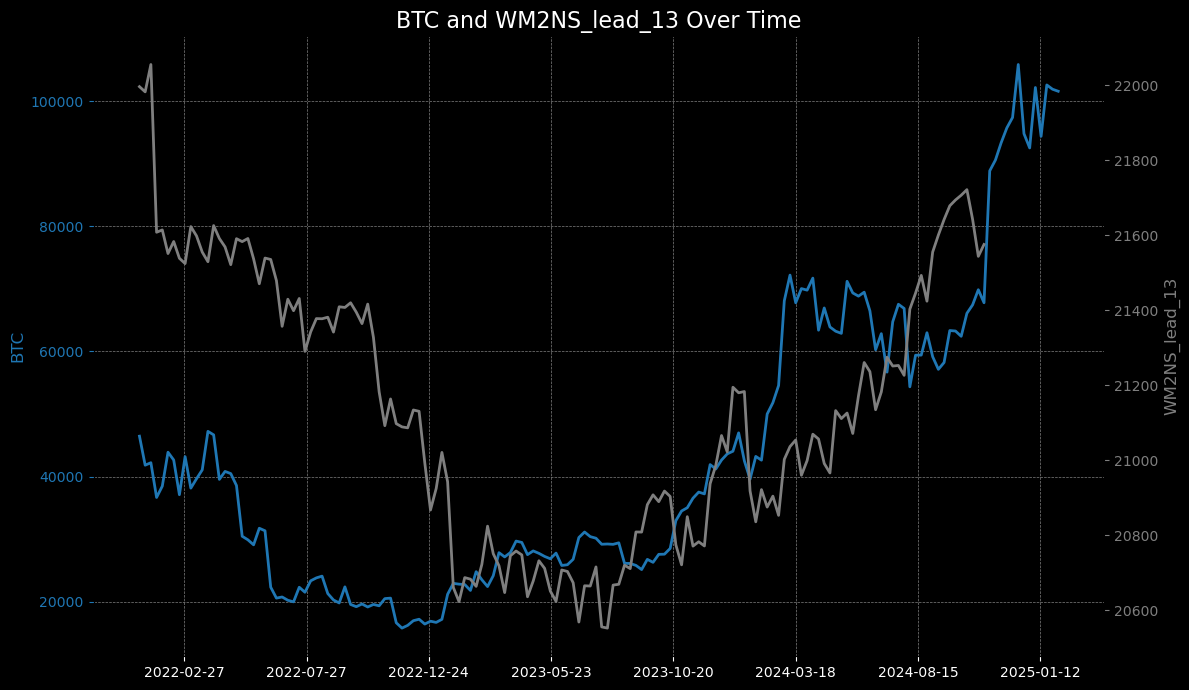

In [29]:
process_and_plot(m2btc_df, from_date='2022-01-01', lead=13)

In [30]:
def cointegration_test(df, col1, col2, period_name, lead_weeks):
    """
    Performs the Engle-Granger cointegration test between two non-stationary time series
    and returns a formatted result.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the series.
    - col1 (str): The first column for the test (e.g., 'BTC').
    - col2 (str): The second column for the test (e.g., 'WM2NS_lead_{lead_weeks}').
    - period_name (str): Label for the time period being tested.
    - lead_weeks (int): Number of weeks by which M2 is shifted forward.
    
    Returns:
    - str: A formatted string summarizing the cointegration test results.
    """
    # Drop rows with NaN values in either series
    df_clean = df[[col1, col2]].dropna()

    # Perform the Engle-Granger Cointegration Test
    score, p_value, _ = coint(df_clean[col1], df_clean[col2])

    # Determine interpretation based on a 0.05 threshold
    interpretation = "✅ Cointegrated" if p_value < 0.05 else "❌ Not Cointegrated"

    # Approximate month lead using ~4.345 weeks per month
    approx_months = round(lead_weeks / 4.345, 2)

    # Format the output text
    result_text = (
        f"🔍 Engle-Granger Cointegration Test\n"
        f"📅 Time Period: {period_name}\n"
        f"🗓 Using a {lead_weeks}-week shift (~{approx_months} month lead)\n"
        f"----------------------------------\n"
        f"📊 Testing BTC vs. M2 (with a lead of {lead_weeks} weeks)\n"
        f"📉 Cointegration Statistic: {score:.4f}\n"
        f"📊 p-value: {p_value:.6f}\n"
        f"⚖️ Interpretation: {interpretation}\n"
        f"----------------------------------\n"
        f"🧐 If cointegrated, M2 (leading by ~{approx_months} months) predicts BTC movements."
    )
    
    return result_text

In [31]:
def test_cointegration(m2btc_df, lead_weeks=13):
    """
    Tests cointegration between BTC and the M2 series (shifted forward by a given number of weeks)
    across various time windows.
    
    Parameters:
    - m2btc_df (pd.DataFrame): Input DataFrame containing at least columns 'BTC' and 'WM2NS'.
    - lead_weeks (int): Number of weeks to shift WM2NS forward (must be > 0).
    """
    # Create a complete copy of the dataset
    complete_data_df = m2btc_df.copy()

    # Create a new column for WM2NS shifted forward by lead_weeks
    col_name = f'WM2NS_lead_{lead_weeks}'
    complete_data_df[col_name] = complete_data_df['WM2NS'].shift(-lead_weeks)

    # Define various time windows
    all_data_df = complete_data_df.copy()                    # All historical data
    recent_data_df = complete_data_df.loc['2017-01-01':].copy()  # Last 8 years of data
    post_covid_data_df = complete_data_df.loc['2022-01-01':].copy()  # Post-COVID data

    # Run cointegration tests on each window
    result_all = cointegration_test(all_data_df, 'BTC', col_name, "All Historical Data", lead_weeks)
    result_recent = cointegration_test(recent_data_df, 'BTC', col_name, "Last 8 Years", lead_weeks)
    result_post_covid = cointegration_test(post_covid_data_df, 'BTC', col_name, "Post-COVID", lead_weeks)

    # Print results for easy copy-pasting
    print(result_all)
    print("\n" + "-" * 50 + "\n")
    print(result_recent)
    print("\n" + "-" * 50 + "\n")
    print(result_post_covid)
    
# To test the functions, simply call:
test_cointegration(m2btc_df, lead_weeks=13)

🔍 Engle-Granger Cointegration Test
📅 Time Period: All Historical Data
🗓 Using a 13-week shift (~2.99 month lead)
----------------------------------
📊 Testing BTC vs. M2 (with a lead of 13 weeks)
📉 Cointegration Statistic: -2.0665
📊 p-value: 0.493895
⚖️ Interpretation: ❌ Not Cointegrated
----------------------------------
🧐 If cointegrated, M2 (leading by ~2.99 months) predicts BTC movements.

--------------------------------------------------

🔍 Engle-Granger Cointegration Test
📅 Time Period: Last 8 Years
🗓 Using a 13-week shift (~2.99 month lead)
----------------------------------
📊 Testing BTC vs. M2 (with a lead of 13 weeks)
📉 Cointegration Statistic: -2.0530
📊 p-value: 0.500949
⚖️ Interpretation: ❌ Not Cointegrated
----------------------------------
🧐 If cointegrated, M2 (leading by ~2.99 months) predicts BTC movements.

--------------------------------------------------

🔍 Engle-Granger Cointegration Test
📅 Time Period: Post-COVID
🗓 Using a 13-week shift (~2.99 month lead)
-------

### Last Hope for a Statistically Significant Relationship Between BTC & M2

I thought I would be rich by now, maybe let's try every possible lag between 0 weeks and 52 weeks:

In [34]:
def run_simple_cointegration_tests_for_lags(df, col1='BTC', col2='WM2NS', lead_max=52):
    """
    Runs the Engle-Granger cointegration test across lags (0 to lead_max weeks) and returns
    a dictionary mapping each lag to a simple cointegration result string.
    
    Parameters:
      - df (pd.DataFrame): DataFrame containing at least the columns col1 and col2.
      - col1 (str): The first column (e.g., 'BTC').
      - col2 (str): The second column (e.g., 'WM2NS').
      - lead_max (int): Maximum lag (in weeks) to test.
      
    Returns:
      - dict: Mapping from lag (int) to a simple result string (e.g., "✅ Cointegrated").
    """
    results = {}
    for lag in range(lead_max + 1):
        df_lagged = df.copy()
        shifted_col = f'{col2}_lead_{lag}'
        df_lagged[shifted_col] = df_lagged[col2].shift(-lag)
        df_lagged = df_lagged.dropna(subset=[col1, shifted_col])
        
        # Perform the cointegration test between BTC and the shifted WM2NS
        _, p_value, _ = coint(df_lagged[col1], df_lagged[shifted_col])
        interpretation = "✅ Cointegrated" if p_value < 0.05 else "❌ Not Cointegrated"
        results[lag] = interpretation
    return results

In [35]:
# Define time periods
entire_df = m2btc_df.copy()
recent_df = m2btc_df.loc['2017-01-01':].copy()
post_covid_df = m2btc_df.loc['2022-01-01':].copy()

# Run simple cointegration tests for each period
results_all = run_simple_cointegration_tests_for_lags(entire_df, lead_max=52)
results_recent = run_simple_cointegration_tests_for_lags(recent_df, lead_max=52)
results_post_covid = run_simple_cointegration_tests_for_lags(post_covid_df, lead_max=52)

# Print simple summary for each period
print("All Data:")
for lag, res in results_all.items():
    print(f"{lag} week lag: {res}")

print("\nLast 8 Years:")
for lag, res in results_recent.items():
    print(f"{lag} week lag: {res}")

print("\nPost-COVID:")
for lag, res in results_post_covid.items():
    print(f"{lag} week lag: {res}")

All Data:
0 week lag: ❌ Not Cointegrated
1 week lag: ❌ Not Cointegrated
2 week lag: ❌ Not Cointegrated
3 week lag: ❌ Not Cointegrated
4 week lag: ❌ Not Cointegrated
5 week lag: ❌ Not Cointegrated
6 week lag: ❌ Not Cointegrated
7 week lag: ❌ Not Cointegrated
8 week lag: ❌ Not Cointegrated
9 week lag: ❌ Not Cointegrated
10 week lag: ❌ Not Cointegrated
11 week lag: ❌ Not Cointegrated
12 week lag: ❌ Not Cointegrated
13 week lag: ❌ Not Cointegrated
14 week lag: ❌ Not Cointegrated
15 week lag: ❌ Not Cointegrated
16 week lag: ❌ Not Cointegrated
17 week lag: ❌ Not Cointegrated
18 week lag: ❌ Not Cointegrated
19 week lag: ❌ Not Cointegrated
20 week lag: ❌ Not Cointegrated
21 week lag: ❌ Not Cointegrated
22 week lag: ❌ Not Cointegrated
23 week lag: ❌ Not Cointegrated
24 week lag: ❌ Not Cointegrated
25 week lag: ❌ Not Cointegrated
26 week lag: ❌ Not Cointegrated
27 week lag: ❌ Not Cointegrated
28 week lag: ❌ Not Cointegrated
29 week lag: ❌ Not Cointegrated
30 week lag: ❌ Not Cointegrated
31 week 

/var/folders/4w/nd1gpmp52qbd4726k116vdhm0000gn/T/ipykernel_18452/2156481339.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([plot_df, extension_df])


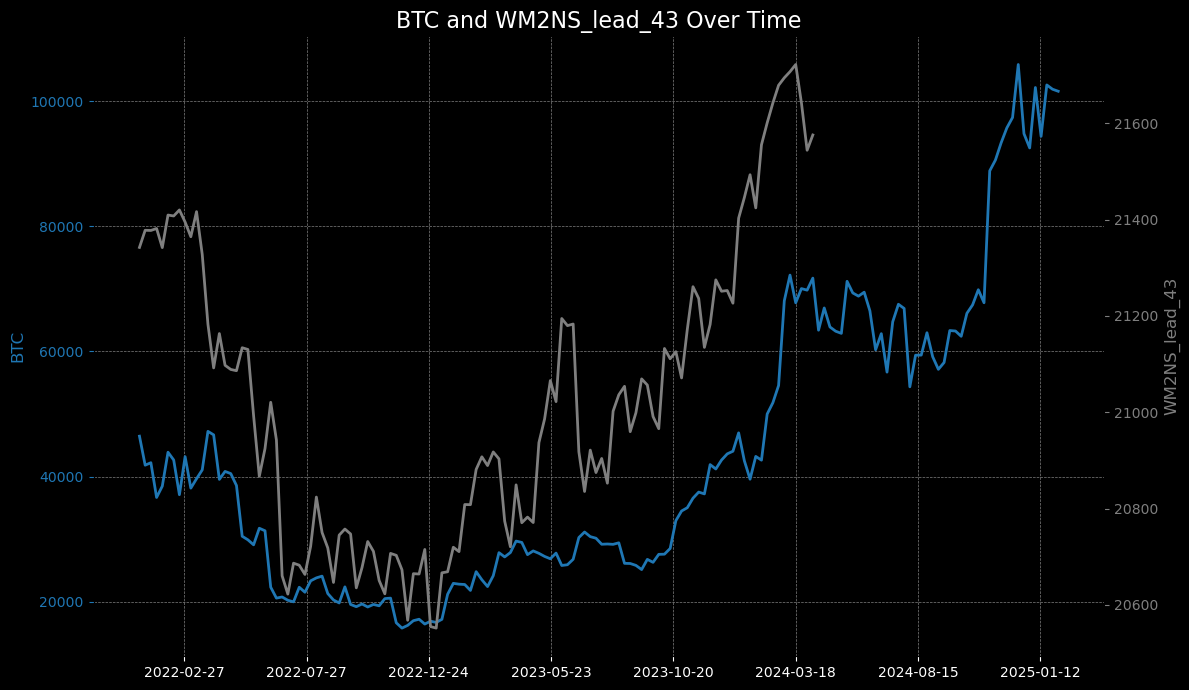

In [36]:
process_and_plot(m2btc_df, from_date='2022-01-01', lead=43)

We've essentially been 'fishing' for significance by testing over 150 different temporal alignments between Bitcoin and US M2. In all cases except one—specifically, the 43-week lead on US M2 for post-2022 data—the cointegration tests failed to show any significant relationship. This strongly suggests that there's no meaningful long-run equilibrium linking Bitcoin to a leading measure of US M2. That single significant result is most likely a chance occurrence—an artifact of multiple comparisons—rather than evidence of a substantive economic connection.

Unfortunately, neither of us will be rich trading Bitcoin using US M2. Feel free to send 'Global M2' for similar tests.